<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Multiclass(4)_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 classes classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
#np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

## Read, Split train_val & oversample train set


In [4]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']

df_['Retinopathy grade'] = df['Retinopathy grade']

df_=df_[df_['Retinopathy grade']>0]
train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade
403,IDRiD_404,2
6,IDRiD_007,4
121,IDRiD_122,2
378,IDRiD_379,1
374,IDRiD_375,2


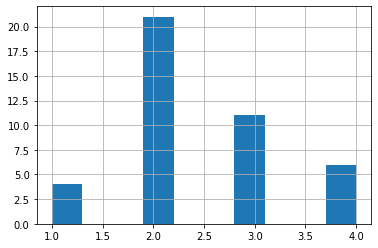

In [5]:
val_df['Retinopathy grade'].hist()

In [6]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 460 Old Size: 237


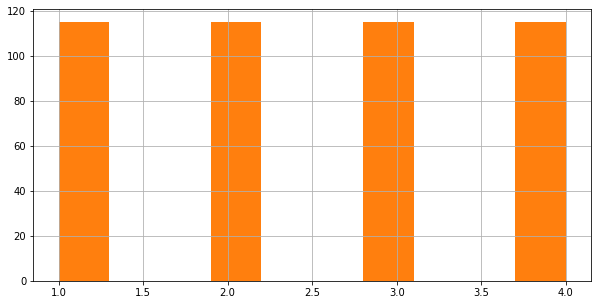

In [7]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [8]:
image_names = train_df['Image name'];
im_size = 512;

train_labels = [];
for label in train_df['Retinopathy grade']:
    #for i in range(2): # 2 times for data augmentation
    train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((len(train_labels),im_size,im_size,3))

index=0
for image_name in image_names:
    #read image
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index,:,:,0:3] = img

    #rot 180
    #train_images[index + 1] = np.rot90(np.rot90(img))
    
    index = index + 1

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  460
(460, 512, 512, 3)
(460, 4)


array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    #brightness_range=[0.,0.01],
    #zca_whitening	=True,
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(train_images)

## Read test_df


In [10]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df_=test_df_[test_df_['Retinopathy grade']>0]
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


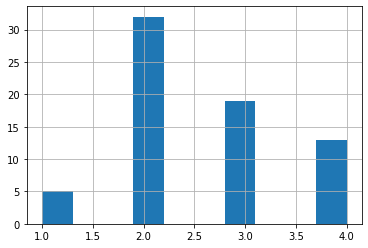

In [11]:
test_df['Retinopathy grade'].hist()

In [12]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  69
(69, 512, 512, 3)
(69, 4)


In [13]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of val set ",len(val_image_names))
im_size = 512;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);
print("max value of image ",np.max(val_images))
val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of val set  42
max value of image  255
(42, 512, 512, 3)
(42, 4)


In [14]:
val_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
val_datagen.fit(val_images)

In [15]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (460, 512, 512, 3)
train y size  (460, 4)
test x size  (69, 512, 512, 3)
test y size  (69, 4)
val x size  (42, 512, 512, 3)
val y size  (42, 4)


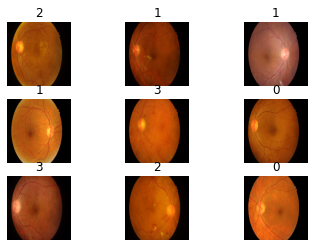

In [16]:
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(train_images[2*i+1])
  plt.title("{}".format(np.argmax(train_labels[2*i+1]))) 
  plt.axis('off')

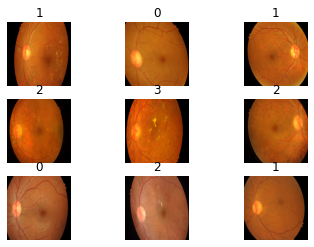

In [17]:
x=train_datagen.flow(train_images, train_labels,batch_size=9,shuffle=True)
for i,(img,lbl) in enumerate(x):
  for j in range(9):
    ax=plt.subplot(3,3,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break
del x

In [18]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [19]:
from tensorflow.keras.models import model_from_json

def load_seg_model(model_name):
    """
    loads the pretrained seg model of given lesion
    """
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/{}.h5".format(model_name))
    # print("Loaded model from disk")

    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

model_EX  Model loaded and compiled


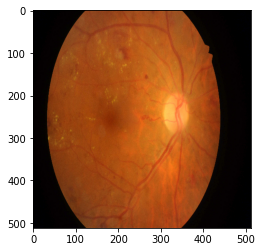

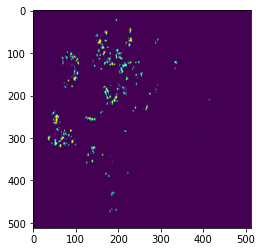

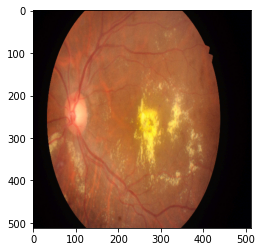

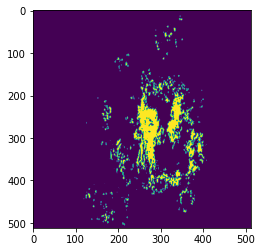

In [20]:
se_model=load_seg_model("model_EX")
for i in range(2):
  lesion=se_model(val_images[i:1+i,:,:,:])
  plt.imshow(val_images[i,:,:,:])
  plt.show()
  plt.imshow(np.squeeze(np.squeeze(lesion,axis=0),axis=2))
  plt.show()

model_MA  Model loaded and compiled


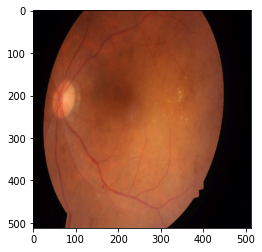

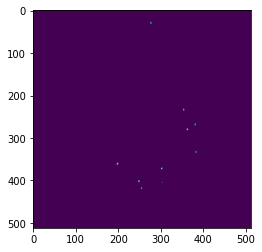

In [21]:
#to check if the augmentationi affecteing the lesions
se_model=load_seg_model("model_MA")
x=train_datagen.flow(train_images, train_labels,batch_size=1,shuffle=True)
for i,(img_,lbl) in enumerate(x):
  lesion=se_model(img_)
  plt.imshow((np.squeeze(img_,axis=0)))
  plt.show()
  plt.imshow(np.squeeze(np.squeeze(lesion,axis=0),axis=2))
  plt.show()
  break

In [22]:
def build_model(num_classes,model_name):
    random.seed = 1337
    tf.seed = 1337
    tf.random.set_seed(1337)
    
    IMG_SIZE=224
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_densenet')(input_0)
    #input_0_ma  =tf.keras.layers.experimental.preprocessing.Resizing(640,640,  name='resize_ma')(input_0)
    #input_1 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    #input_ex=layers.Input(shape=(512,512,1))
    #input_se=layers.Input(shape=(512,512,1))
    #input_ma=layers.Input(shape=(640,640,1))
    if model_name=='DenseNet121':
      base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    elif model_name=='EfficientNetB0':
      base_model = EfficientNetB0(include_top=False, input_tensor=input_1*255, weights="imagenet")
    ex_model=load_seg_model("model_EX")
    ma_model=load_seg_model("model_MA")
    se_model=load_seg_model("model_SE")
    he_model=load_seg_model("model_HE_1")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False
    ex_model._name='model_ex'
    ma_model._name='model_ma'
    se_model._name='model_se'
    he_model._name='model_he'
    for layer in he_model.layers:
      layer._name = layer.name + '_he'
    for layer in se_model.layers:
      layer._name = layer.name + '_se'
    for layer in ex_model.layers:
      layer._name = layer.name + '_ex'
    for layer in ma_model.layers:
      layer._name = layer.name + '_ma'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)
    #les_ma=tf.keras.layers.experimental.preprocessing.Resizing(640,640,  name='resize_ma')(les_ma)
    f_lesions=layers.Concatenate()([les_ex,les_se,les_ma,les_he])
    #block1
    f_lesions=Conv2D(8,3,strides=(2,2),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='1_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block2
    f_lesions=Conv2D(16,3,strides=(2,2),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='2_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block3
    f_lesions=Conv2D(32,3,strides=(2,2),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='3_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block4
    #f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    #f_lesions=layers.BatchNormalization(name='4_bn')(f_lesions)
    #f_lesions=layers.Activation('relu')(f_lesions)
    #f_lesions=MaxPooling2D()(f_lesions)
    #block5 
    #f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    #f_lesions=layers.BatchNormalization(name='5_bn')(f_lesions)
    #f_lesions=layers.Activation('relu',)(f_lesions)
    #f_lesions=MaxPooling2D()(f_lesions)
    #block6
    #f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    #f_lesions=layers.BatchNormalization(name='6_bn')(f_lesions)
    #f_lesions=layers.Activation('relu')(f_lesions)
    #f_lesions=MaxPooling2D()(f_lesions)
    
    f_lesions=layers.GlobalMaxPooling2D()(f_lesions)
    #print(f_lesions.shape)
    x=layers.GlobalAveragePooling2D()(base_model.output)
    x=layers.Concatenate()([x,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten")(x)
    
    top_dropout_rate = 0.2
    #x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_1")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input_0, outputs, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [23]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model=build_model(4,'EfficientNetB0')

16711680/16705208 [==============================] - 0s 0us/step
model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled


In [24]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 6,267,549
Trainable params: 409,164
Non-trainable params: 5,858,385


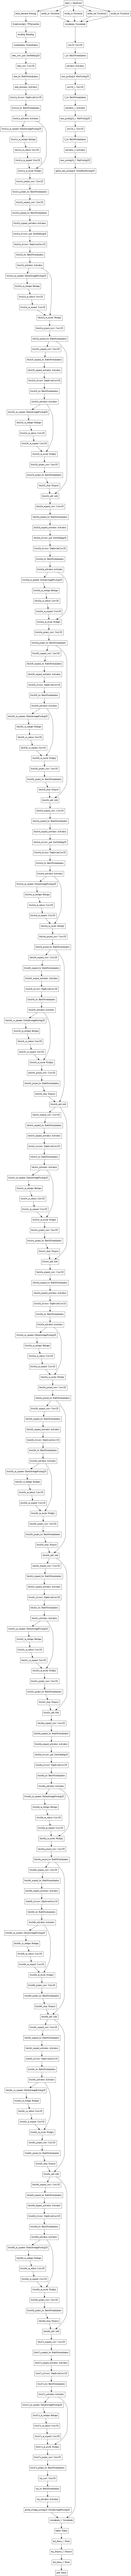

In [25]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [26]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 8)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=10,shuffle=True),steps_per_epoch=len(train_images) / 10,
               epochs = 50, callbacks = [early_stopping],validation_data=val_datagen.flow(val_images,val_labels,batch_size=10));

Epoch 1/50
46/46 [==============================] - 65s 998ms/step - loss: 1.3213 - accuracy: 0.3272 - val_loss: 1.6430 - val_accuracy: 0.0952
Epoch 2/50
46/46 [==============================] - 39s 843ms/step - loss: 1.0283 - accuracy: 0.5537 - val_loss: 1.9942 - val_accuracy: 0.0952
Epoch 3/50
46/46 [==============================] - 40s 858ms/step - loss: 0.9265 - accuracy: 0.5933 - val_loss: 2.3557 - val_accuracy: 0.0952
Epoch 4/50
46/46 [==============================] - 41s 874ms/step - loss: 0.8636 - accuracy: 0.5958 - val_loss: 2.3019 - val_accuracy: 0.1429
Epoch 5/50
46/46 [==============================] - 40s 870ms/step - loss: 0.8060 - accuracy: 0.5886 - val_loss: 2.3196 - val_accuracy: 0.1190
Epoch 6/50
46/46 [==============================] - 40s 871ms/step - loss: 0.8650 - accuracy: 0.5899 - val_loss: 2.3575 - val_accuracy: 0.1667
Epoch 7/50
46/46 [==============================] - 40s 873ms/step - loss: 0.7264 - accuracy: 0.6853 - val_loss: 1.8492 - val_accuracy: 0.1905

[[ 3  1  0  0]
 [ 2 12  6  1]
 [ 1  2  5  3]
 [ 0  1  1  4]]
0.5714285714285714  accuracy


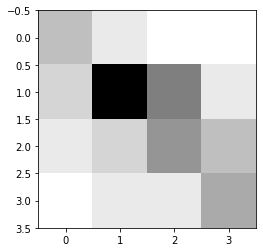

In [27]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_=np.zeros((val_labels.shape))
for i in range(7):
  pred_y_[6*i:6*i+6]=model.predict(val_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))," accuracy")

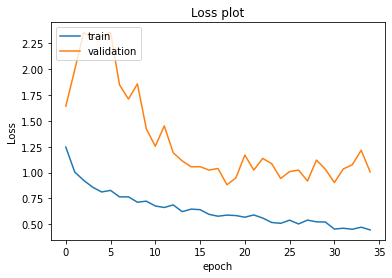

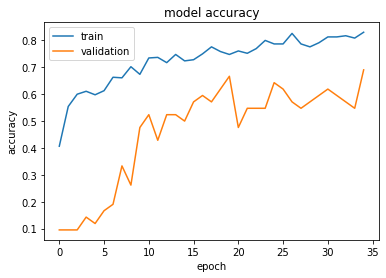

In [28]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

[[ 3  2  0  0]
 [ 5 22  5  0]
 [ 1  6 10  2]
 [ 1  1  6  5]]
0.5797101449275363  acuracy


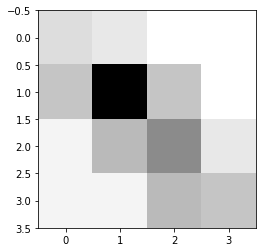

In [54]:
#preds = model.evaluate(test_images, test_labels)
#print("Loss = " + str(preds[0]))
#print("Test accuracy = " + str(preds[1]))
pred_y_=np.zeros((test_labels.shape))
for i in range(12):
  pred_y_[6*i:6*i+6]=model.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

## acc with TTA

In [57]:
test_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
test_datagen.fit(test_images)
pred_y_tta=np.zeros((69,4))
x=test_datagen.flow(test_images,test_labels,batch_size=10)
test_y_=np.zeros((69,4))

Adding
[[ 4  1  0  0]
 [ 4 20  7  1]
 [ 1  5 11  2]
 [ 1  2  5  5]]
0.5797101449275363  acuracy
Adding
[[ 4  1  0  0]
 [ 7 19  6  0]
 [ 1  6 11  1]
 [ 0  2  5  6]]
0.5797101449275363  acuracy
Adding
[[ 4  1  0  0]
 [ 6 21  3  2]
 [ 1  5 12  1]
 [ 0  1  5  7]]
0.6376811594202898  acuracy
Adding
[[ 4  1  0  0]
 [ 6 21  4  1]
 [ 1  8  9  1]
 [ 0  1  7  5]]
0.5652173913043478  acuracy
Adding
[[ 5  0  0  0]
 [ 6 19  6  1]
 [ 1  6 11  1]
 [ 0  2  7  4]]
0.5652173913043478  acuracy
Adding
[[ 3  2  0  0]
 [ 6 15  8  3]
 [ 1  6 10  2]
 [ 1  1  5  6]]
0.4927536231884058  acuracy
Adding
[[ 4  1  0  0]
 [ 5 21  5  1]
 [ 1  6 11  1]
 [ 1  2  7  3]]
0.5652173913043478  acuracy
Adding
[[ 4  1  0  0]
 [ 5 20  6  1]
 [ 1  5 13  0]
 [ 0  2  6  5]]
0.6086956521739131  acuracy
Adding
[[ 4  1  0  0]
 [ 7 19  6  0]
 [ 1  6 11  1]
 [ 0  3  6  4]]
0.5507246376811594  acuracy
Adding
[[ 4  1  0  0]
 [ 5 19  7  1]
 [ 1  6 11  1]
 [ 1  1  7  4]]
0.5507246376811594  acuracy


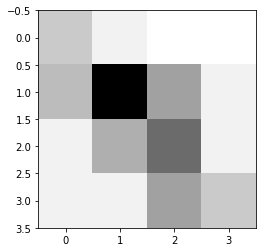

In [60]:
acc=0
for i in range(10):
  for i,(img,lbl) in enumerate(x):
    #print(img.shape,lbl.shape)
    #print(i)
    if i==6:
      print("Adding")
      pred_y_tta[10*i:10*i+9]=model.predict(img)
      test_y_[10*i:10*i+9,:]=lbl
      #print(lbl)
      break
    pred_y_tta[10*i:10*i+10]=model.predict(img)
    #print(lbl)
    test_y_[10*i:10*i+10,:]=lbl

  cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  print(cm)
  plt.imshow(cm, cmap='binary')
  score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  acc+=score
  print(score," acuracy")

In [61]:
print("average acc TTA ",acc/10)

average acc TTA  0.5695652173913043


In [62]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/model_eff_late_fusion.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/model_eff_late_fusion.h5")
print("Saved model to disk")

ValueError: ignored

## unfreeze and train

In [63]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:]=='bn':
    layer.trainable=False
    count+=1
print(count," layers of bn freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

52  layers of bn freezed
Total params: 6,267,549
Trainable params: 6,175,656
Non-trainable params: 91,893


In [65]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
opt = keras.optimizers.Adam(learning_rate = 1e-7, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=2,shuffle=True),steps_per_epoch=len(train_images) / 2,
               epochs = 20,callbacks=[early_stopping],validation_data=val_datagen.flow(val_images,val_labels,batch_size=4));

Epoch 1/20
230/230 [==============================] - 191s 716ms/step - loss: 0.3898 - accuracy: 0.8664 - val_loss: 1.0028 - val_accuracy: 0.6429
Epoch 2/20
230/230 [==============================] - 160s 694ms/step - loss: 0.4309 - accuracy: 0.8255 - val_loss: 0.9936 - val_accuracy: 0.6190
Epoch 3/20
230/230 [==============================] - 160s 694ms/step - loss: 0.4690 - accuracy: 0.8363 - val_loss: 1.0257 - val_accuracy: 0.6905
Epoch 4/20
230/230 [==============================] - 160s 696ms/step - loss: 0.3929 - accuracy: 0.8651 - val_loss: 1.0056 - val_accuracy: 0.5714
Epoch 5/20
230/230 [==============================] - 160s 695ms/step - loss: 0.4144 - accuracy: 0.8396 - val_loss: 0.9400 - val_accuracy: 0.5714
Epoch 6/20
230/230 [==============================] - 160s 695ms/step - loss: 0.4479 - accuracy: 0.8057 - val_loss: 1.0552 - val_accuracy: 0.5476


[[ 3  2  0  0]
 [ 6 19  5  2]
 [ 0  8  6  5]
 [ 1  1  4  7]]
0.5072463768115942  acuracy


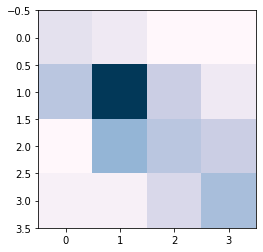

In [68]:
pred_y_=np.zeros((test_labels.shape))
for i in range(12):
  pred_y_[6*i:6*i+6]=model.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='PuBu')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

Adding
[[ 4  1  0  0]
 [ 4 20  7  1]
 [ 1  7  8  3]
 [ 0  2  5  6]]
0.5507246376811594  acuracy
Adding
[[ 3  2  0  0]
 [ 8 16  7  1]
 [ 1  7  9  2]
 [ 1  0  3  9]]
0.5362318840579711  acuracy
Adding
[[ 4  1  0  0]
 [ 5 17  7  3]
 [ 1  7  9  2]
 [ 0  4  3  6]]
0.5217391304347826  acuracy
Adding
[[ 4  1  0  0]
 [ 3 19  9  1]
 [ 1  6 10  2]
 [ 1  1  4  7]]
0.5797101449275363  acuracy
Adding
[[ 4  1  0  0]
 [ 6 20  4  2]
 [ 1  7  9  2]
 [ 0  3  2  8]]
0.5942028985507246  acuracy
Adding
[[ 4  1  0  0]
 [ 5 21  4  2]
 [ 1  5  8  5]
 [ 1  2  5  5]]
0.5507246376811594  acuracy
Adding
[[ 4  1  0  0]
 [ 8 16  6  2]
 [ 1  7  8  3]
 [ 0  3  2  8]]
0.5217391304347826  acuracy
Adding
[[ 2  3  0  0]
 [ 6 20  6  0]
 [ 1  6 10  2]
 [ 1  1  5  6]]
0.5507246376811594  acuracy
Adding
[[ 4  1  0  0]
 [ 5 22  5  0]
 [ 1  7  9  2]
 [ 1  2  4  6]]
0.5942028985507246  acuracy
Adding
[[ 3  2  0  0]
 [ 7 18  7  0]
 [ 1  6 10  2]
 [ 1  2  3  7]]
0.5507246376811594  acuracy


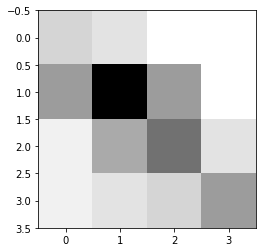

In [69]:
pred_y_tta=np.zeros((69,4))
test_y_=np.zeros((69,4))
acc=0
for i in range(10):
  for i,(img,lbl) in enumerate(x):
    #print(img.shape,lbl.shape)
    #print(i)
    if i==6:
      print("Adding")
      pred_y_tta[10*i:10*i+9]=model.predict(img)
      test_y_[10*i:10*i+9,:]=lbl
      #print(lbl)
      break
    pred_y_tta[10*i:10*i+10]=model.predict(img)
    #print(lbl)
    test_y_[10*i:10*i+10,:]=lbl

  cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  print(cm)
  plt.imshow(cm, cmap='binary')
  score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  acc+=score
  print(score," acuracy")

In [70]:
print(acc/10," avg acuracy")

0.5550724637681159  avg acuracy


## Show outputs of lesion maps and further layers

In [154]:
#model.summary()

In [163]:
k=0
for layer in model.layers:
  k+=1
  if layer.name=='model_ex':
    les_=layer(train_images[:10])
  if layer.name=='conv2d':
    index=k

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


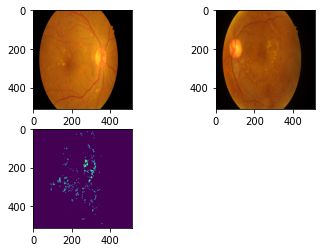

In [166]:
for i in range(2):
  plt.subplot(2,2,i+1)
  plt.imshow(train_images[i])
  plt.subplot(2,2,i+2)
  plt.imshow(np.squeeze(les_[i],axis=2))

In [150]:
le=model.layers[index-1].output

In [151]:
from keras import backend as K
fun=K.function(model.input,le)
les_=fun(train_images[:10])

(10, 256, 256, 8)


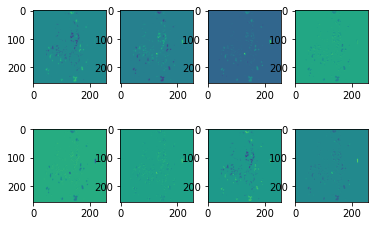

In [157]:
print(les_.shape)
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(les_[1,:,:,i])